In [51]:
import modin.pandas as pd
from transformers import AutoTokenizer

# import swifter

In [52]:
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/deberta-v3-large", do_lower_case=True
)

In [53]:
label_to_int = {"winner_model_a": 0, "winner_model_b": 1, "tie": 2}

In [54]:
df = pd.read_csv("../data/train.csv")
print(df.columns)

Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie'],
      dtype='object')


In [55]:
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [56]:
import json


def safe_eval(s):
    try:
        return json.loads(s.replace("null", '""'))
    except (ValueError, SyntaxError, json.JSONDecodeError):
        # If parsing fails, return the input itself if it's already a list or return an empty list
        if isinstance(s, list):
            return s
        elif isinstance(s, int):
            return [str(s)]
        else:
            return []


# Convert each element to string before joining
def join_elements(elements):
    return " ".join(map(str, elements))


df["prompt"] = df.prompt.map(lambda x: join_elements(safe_eval(x)))
df["response_a"] = df.response_a.map(
    lambda x: join_elements(safe_eval(x.replace("null", "''")))
)
df["response_b"] = df.response_b.map(
    lambda x: join_elements(safe_eval(x.replace("null", "''")))
)
df["label"] = df.apply(
    lambda row: (
        0 if row["winner_model_a"] == 1 else 1 if row["winner_model_b"] == 1 else 2
    ),
    axis=1,
)

In [57]:
source_prefix = "<|source|>"
cand1_prefix = "<|candidate1|>"
cand2_prefix = "<|candidate2|>"


def make_pairs(row):
    row["encode_fail"] = False
    prompt = row.prompt.encode("utf-8", errors="ignore").decode("utf-8")
    response_a = row.response_a.encode("utf-8", errors="ignore").decode("utf-8")
    response_b = row.response_b.encode("utf-8", errors="ignore").decode("utf-8")
    row["left"] = f"<|source|> {prompt}\n\n\n\n <|candidate|> {response_a}"
    row["right"] = f"<|source|> {prompt}\n\n\n\n <|candidate|> {response_b}"

    if prompt == "" or response_a == "" or response_b == "":
        row["encode_fail"] = True
        row["pairrm"] = None
    else:
        row["pairrm"] = (
            f"{source_prefix} {prompt}\n\n\n\n{cand1_prefix} {response_a}\n\n\n\n{cand2_prefix} {response_b}"
        )
    return row

In [58]:
df = df.apply(make_pairs, axis=1)

In [59]:
# count of none in pair
print(df.encode_fail.value_counts())

encode_fail
False    57116
True       361
Name: count, dtype: int64


In [60]:
# drop rows with encode_fail
df = df[df.encode_fail == False]

In [61]:
# destibution of len of pairrm
df["left_len"] = df.left.map(lambda x: len(x))
df["left_tokens_len"] = df.left.map(
    lambda x: len(
        tokenizer.encode_plus(
            x,
            None,
            add_special_tokens=True,
        )["input_ids"]
    )
)

df["right_len"] = df.right.map(lambda x: len(x))
df["right_tokens_len"] = df.right.map(
    lambda x: len(
        tokenizer.encode_plus(
            x,
            None,
            add_special_tokens=True,
        )["input_ids"]
    )
)

<Axes: >

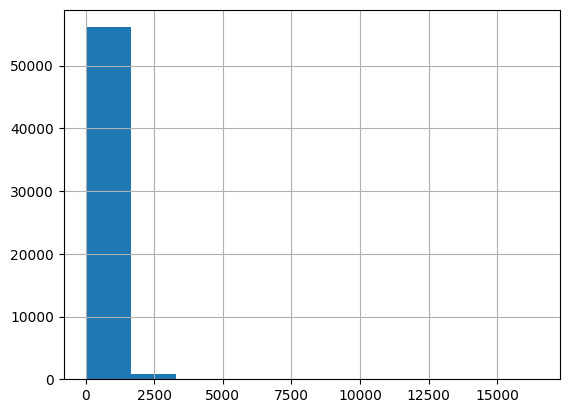

In [62]:
df.right_tokens_len.hist()

<Axes: >

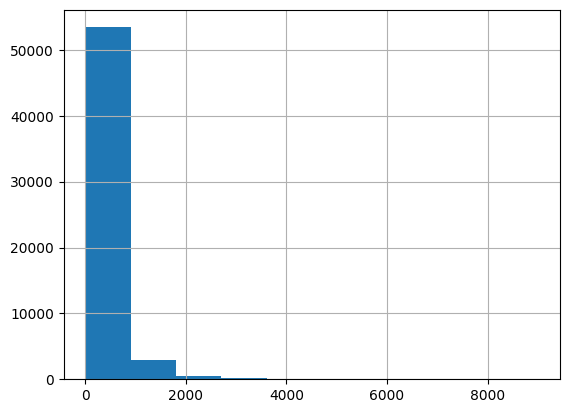

In [63]:
df.left_tokens_len.hist()

In [64]:
# longest pairrm row
# print(df.pairrm_len.max())
# print(df.pairrm_len.idxmax())

In [65]:
# len(df.iloc[df.pairrm_len.idxmax()]["pairrm"])

In [66]:
# drop rows with pairrm_len > 4096
# df = df[df.left_tokens_len <= 2048]
# df = df[df.right_tokens_len <= 2048]

<Axes: >

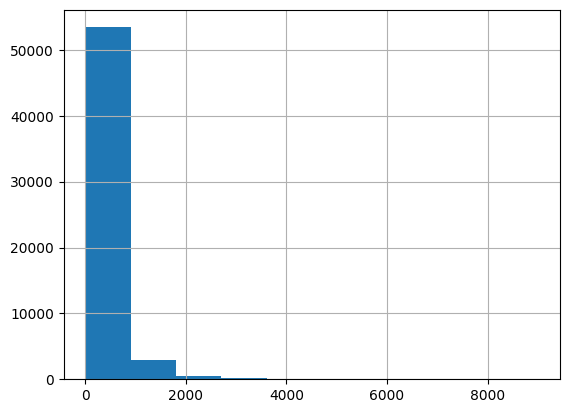

In [67]:
# destibution of len of pairrm
df.left_tokens_len.hist()

In [68]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 57116 entries, 0 to 57476
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                57116 non-null  int64 
 1   model_a           57116 non-null  object
 2   model_b           57116 non-null  object
 3   prompt            57116 non-null  object
 4   response_a        57116 non-null  object
 5   response_b        57116 non-null  object
 6   winner_model_a    57116 non-null  int64 
 7   winner_model_b    57116 non-null  int64 
 8   winner_tie        57116 non-null  int64 
 9   label             57116 non-null  int64 
 10  encode_fail       57116 non-null  bool  
 11  left              57116 non-null  object
 12  right             57116 non-null  object
 13  pairrm            57116 non-null  object
 14  left_len          57116 non-null  int64 
 15  left_tokens_len   57116 non-null  int64 
 16  right_len         57116 non-null  int64 
 17  right_tokens

In [69]:
df[["left", "right", "label", "pairrm"]].to_csv("../data/train_pairs.csv", index=False)

In [5]:
from ignite.engine import Events
import torch
from ignite.metrics import Accuracy, Precision, Recall, Fbeta

In [23]:
y = torch.tensor([[0, 0, 1], [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0]])
y_pred = torch.tensor([[0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]])

print(y.shape)
print(y_pred.shape)

# accuracy = Accuracy(is_multilabel=True)
# accuracy.reset()
# accuracy.update((y_pred, y))
# accuracy.compute()

precision = Precision(average=False, is_multilabel=True)
precision.reset()
precision.update((y_pred, y))
precision.compute()

recall = Recall(average=False, is_multilabel=True)
recall.reset()
recall.update((y_pred, y))
recall.compute()

fbeta = Fbeta(average=False, beta=0.5)
fbeta.reset()
fbeta.update((y_pred, y))
fbeta.compute()

print(f"Precision: {precision.compute()}")
print(f"Recall: {recall.compute()}")
print(f"Fbeta: {fbeta.compute()}")

torch.Size([5, 3])
torch.Size([5, 3])
Precision: tensor([0.0000, 1.0000, 0.5000], dtype=torch.float64)
Recall: tensor([0.0000, 0.6667, 1.0000], dtype=torch.float64)
Fbeta: 0.5999999999999991
